# 2. Data Cleaning & EDA

Exploratory Data Analysis (EDA) is a crucial step in processing and analyzing textual data. This presentation will address EDA from the perspective of semantics and textual data preparation, aiming to understand patterns, structures, and relationships within the text.

## Objectives

1. Understand the structure and distribution of textual data.

2. Identify key patterns, such as the most frequent words and associations.

3. Detect anomalous values or null data that may affect subsequent analysis.

4. Prepare textual data for semantic models through cleaning, normalization, and lemmatization.

In [38]:
# Imports
## Core 
import numpy as np
import pandas as pd

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Statistical Analysis
from scipy.stats import ttest_ind

## Text processing
import re ## Regular expressions - Pattern matching and text substitution
          
import nltk ## Natural Language Toolkit (nltk): For various NLP tasks including:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

from nltk.sentiment import SentimentIntensityAnalyzer #Sentiment Analysis

## Visualization of Text
from wordcloud import WordCloud

# Feature Extraction - text vectorization:
# CountVectorizer: Creates a frequency matrix of terms.
# TfidfVectorizer: Generates term frequency-inverse document frequency matrices.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [2]:
#1. Loading and Initial Exploration

df = pd.read_csv('Datasets/post_reddit_edit_2411.csv')

In [3]:
df.isnull().sum()

created_utc           0
title                 0
self_text           366
type_user          2279
Description        2374
subreddit             0
num_comments          0
score                 0
upvote_ratio          0
url                   0
file_date             0
file_hour             0
file_type             0
is_self             328
link_flair_text    2370
author              348
info_url           1709
media                 0
dtype: int64

Variables are removed due to lack of relevant information or a large number of null values.


In [4]:
# 2. Cleaning and Normalization
df.drop(columns=['url',
                 'file_date',
                 'file_hour',
                 'file_type',
                 'is_self',
                 'created_utc',
                 'link_flair_text',
                 'info_url'], axis=1,inplace=True)    

In [5]:
df.shape

(2726, 10)

In [6]:
def dummy(var, new_var):
    df[new_var] = df[var].apply(lambda x: 0 if pd.isnull(x) else 1)
    return df

dummy('self_text','has_self_text')
dummy('author','has_author')

df['self_text'] = df['self_text'].apply(lambda x: " " if pd.isnull(x) else x)
df['author'] = df['author'].apply(lambda x: "Anonymous" if pd.isnull(x) else x)

In [7]:
df['has_self_text'].value_counts()

has_self_text
1    2360
0     366
Name: count, dtype: int64

In [8]:
df.isnull().sum()

title               0
self_text           0
type_user        2279
Description      2374
subreddit           0
num_comments        0
score               0
upvote_ratio        0
author              0
media               0
has_self_text       0
has_author          0
dtype: int64

In [9]:
#Distribution of  comments based on subreddit
df['subreddit'].value_counts(normalize=True)

subreddit
doordash    0.565297
UberEATS    0.434703
Name: proportion, dtype: float64

In [10]:
stop_words = set(stopwords.words('english')) 
lemmatizer = WordNetLemmatizer()

In [11]:
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # Emoticonos
                           u"\U0001F300-\U0001F5FF"  # Símbolos y pictogramas
                           u"\U0001F680-\U0001F6FF"  # Transporte y mapas
                           u"\U0001F700-\U0001F77F"  # Alquimia
                           u"\U0001F780-\U0001F7FF"  # Geométricos
                           u"\U0001F800-\U0001F8FF"  # Suplemento de flechas
                           u"\U0001F900-\U0001F9FF"  # Suplemento de emoticonos
                           u"\U0001FA00-\U0001FA6F"  # Variantes adicionales
                           u"\U0001FA70-\U0001FAFF"  # Símbolos adicionales
                           u"\U00002702-\U000027B0"  # Símbolos variados
                           u"\U000024C2-\U0001F251"  # Caracteres adicionales
                           "]+", flags=re.UNICODE)


def extract_emojis(text):
    if pd.isnull(text):
        return []
    return emoji_pattern.findall(text)

# take away em
def remove_emojis(text):
    if pd.isnull(text):
        return text
    return emoji_pattern.sub(r'', text)

# Extract emojis from title and text
df['emojis_title'] = df['title'].apply(extract_emojis)
df['emojis_self_text'] = df['self_text'].apply(extract_emojis)

df['clean_title'] = df['title'].apply(remove_emojis)
df['clean_self_text'] = df['self_text'].apply(remove_emojis)

In [12]:
# Convert in emoji list in str
df['emojis_self_text'] = df['emojis_self_text'].apply(lambda x: " ".join(x) if isinstance(x, list) else "")
df['emojis_title'] = df['emojis_title'].apply(lambda x: " ".join(x) if isinstance(x, list) else "")
df['has_emojis_self_text'] = df['emojis_title'].apply(lambda x: 0 if x=='' else 1)
df['has_emojis_title'] = df['emojis_self_text'].apply(lambda x: 0 if x=='' else 1)

In [13]:
# Función de limpieza y normalización
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('V'):
        return 'v'  # Verbo
    elif treebank_tag.startswith('N'):
        return 'n'  # Sustantivo
    elif treebank_tag.startswith('R'):
        return 'r'  # Adverbio
    elif treebank_tag.startswith('J'):
        return 'a'  # Adjetivo
    else:
        return 'n'  # Default (Sustantivo)

def clean_text(text):
    if pd.isnull(text):  # Manejo de texto nulo
        return ""
    
    # Convertir a minúsculas
    text = text.lower()
    
    # Eliminar URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Quitar caracteres especiales y números
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenización
    tokens = word_tokenize(text)
    
    # Etiquetar las partes del discurso (POS)
    pos_tags = pos_tag(tokens)
    
    # Eliminar stopwords y lematizar usando POS
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) 
              for word, pos in pos_tags if word not in stop_words]
    
    return " ".join(tokens)

# Aplicar limpieza al título y texto
df['clean_title'] = df['title'].apply(clean_text)
df['clean_self_text'] = df['self_text'].apply(clean_text)

# Ver los resultados
df[['title', 'clean_title', 'self_text', 'clean_self_text']].head()

,title,clean_title,self_text,clean_self_text
0,"Dear dashers, stop putting food in front of sc...",dear dashers stop put food front screen door,This happens all the time! My screen door open...,happen time screen door open lock cant access ...
1,If I would have died like this,would die like,The house was nice though lol,house nice though lol
2,grocery order taking almost 5 hours,grocery order take almost hour,i placed a grocery order 4.5 hours ago and the...,place grocery order hour ago dasher finally wa...
3,Holy peak pay batman,holy peak pay batman,by far the most promos ive seen in portland or...,far promos ive see portland oregon
4,Higher peak pay = Over saturated market,high peak pay saturated market,Higher peak pay\n Oversaturated Market\n ...,high peak pay oversaturated market competition...


In [15]:
def tokenizar():
    tokens = text.split()
    
    # Eliminar stopwords y lematizar
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return " ".join(tokens)

In [16]:
df['clean_title'] = df['title'].apply(clean_text)
df['clean_self_text'] = df['self_text'].apply(clean_text)

In [65]:
#4. Visualization

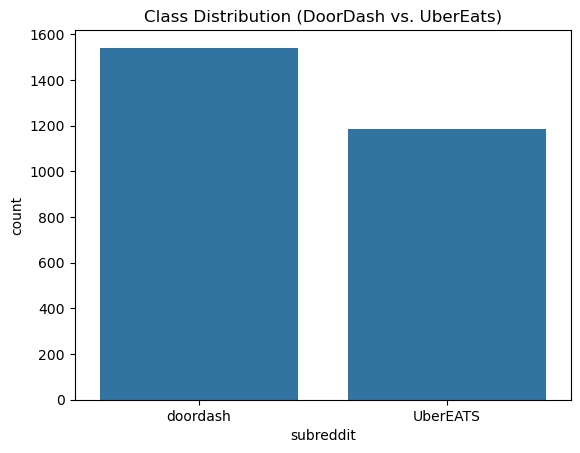

In [19]:
# Count the number of samples per class
sns.countplot(x='subreddit', data=df)
plt.title('Class Distribution (DoorDash vs. UberEats)')
plt.show()

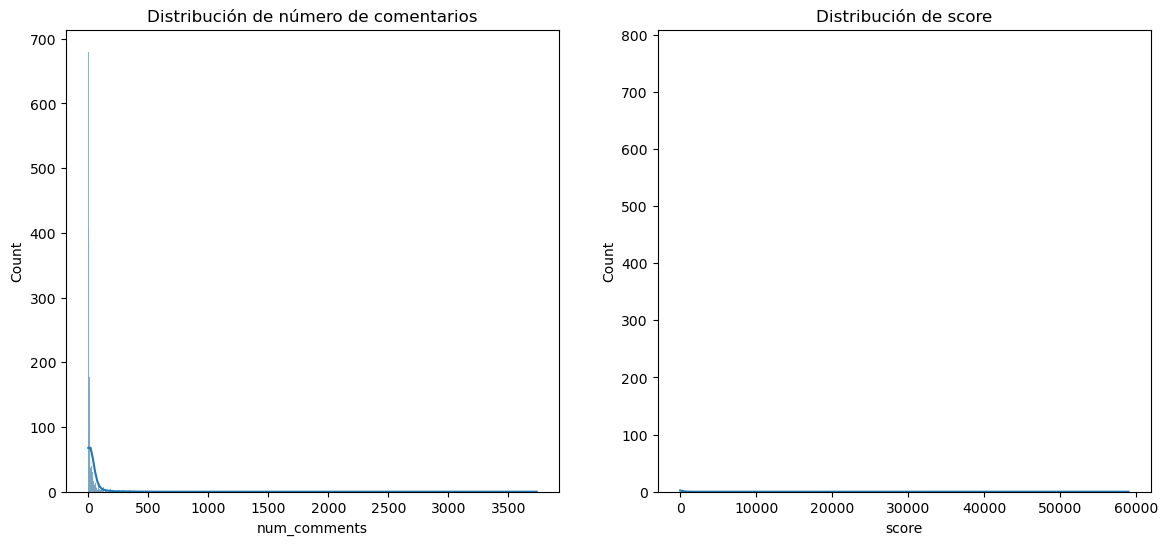

In [20]:
# Histogram to see the distribution of 'num_comments' and 'score'
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(df['num_comments'], kde=True, ax=axes[0]).set_title('Distribution of number of comments')
sns.histplot(df['score'], kde=True, ax=axes[1]).set_title('Distribution of score')

plt.show()

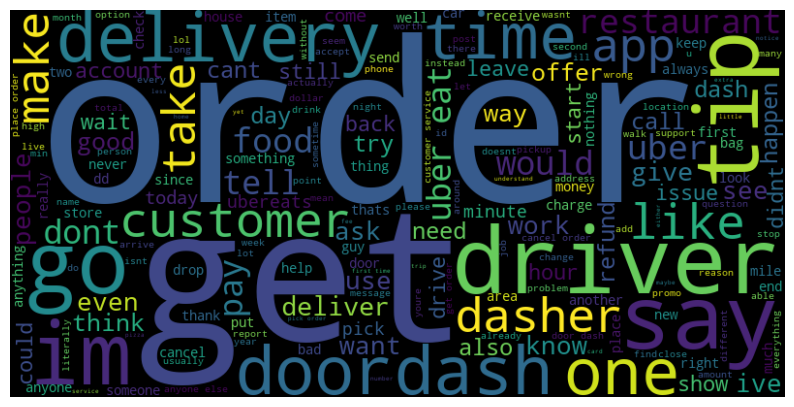

In [24]:
#Word Cloud:
# Generate a word cloud for 'clean_title' or 'clean_self_text'
df['full_text'] = df['clean_title'] + ' ' + df['clean_self_text']

text = ' '.join(df['full_text'])
wordcloud = WordCloud(stopwords='english', width=800, height=400).generate(text)

# Show word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
# We will continue this analisys using an external sources
# https://www.wordclouds.com
# We need to generate a csv with the words and frequency

In [25]:
df['subreddit'].value_counts()

subreddit
doordash    1541
UberEATS    1185
Name: count, dtype: int64

In [26]:

# Filter data for DoorDash and UberEats
df_doordash = df[df['subreddit'] == 'doordash']
df_ubereats = df[df['subreddit'] == 'UberEATS']
df_doordash_clean = df_doordash[df_doordash['clean_self_text'].notnull() & (df_doordash['clean_self_text'] != '')]
df_ubereats_clean = df_ubereats[df_ubereats['clean_self_text'].notnull() & (df_ubereats['clean_self_text'] != '')]

# Function to get the most common words
def get_word_freq(df, column='clean_self_text', top_n=50):
    vectorizer = CountVectorizer(stop_words='english', max_features=top_n)
    X = vectorizer.fit_transform(df[column].dropna())  # Asegúrate de que no haya valores nulos
    
    # Get the words and their frequencies
    word_freq = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0]))
    
    # Transform on a DataFrame
    word_freq_df = pd.DataFrame(list(word_freq.items()), columns=['word', 'frequency'])
    
    # Order Descent
    word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)
    
    return word_freq_df

# Common word dor class, title or self text
door_dash_self_freq_df = get_word_freq(df_doordash_clean,'clean_self_text')
ubereats_self_freq_df = get_word_freq(df_ubereats_clean,'clean_self_text')
door_dash_title_freq_df = get_word_freq(df_doordash,'clean_title')
ubereats_title_freq_df = get_word_freq(df_ubereats,'clean_title')

# Save as CSV
door_dash_self_freq_df.to_csv('Datasets/door_dash_self_freq_df.csv', index=False)
ubereats_self_freq_df.to_csv('Datasets/ubereats_self_freq_df.csv', index=False)
door_dash_title_freq_df.to_csv('Datasets/door_dash_title_freq_df.csv', index=False)
ubereats_title_freq_df.to_csv('Datasets/ubereats_title_freq_df.csv', index=False)

# Mostrar las primeras filas de los resultados
print("Top palabras de DoorDash:")
print(door_dash_self_freq_df.head())

print("\nTop palabras de UberEats:")
print(ubereats_self_freq_df.head())


Top palabras de DoorDash:
        word  frequency
31     order       1429
21        im        617
43       tip        551
42      time        512
14  doordash        487

Top palabras de UberEats:
      word  frequency
29   order       1619
43    uber        888
14  driver        626
36     say        538
19      im        508


In [27]:
vectorizer = CountVectorizer(stop_words='english', max_features=50)  # Solo las 100 palabras más comunes
X = vectorizer.fit_transform(df['clean_self_text'].dropna())  # Asegúrate de que no haya valores nulos

# Obtener las palabras y sus frecuencias
word_freq = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0]))

# Imprimir las palabras más comunes y sus frecuencias
print(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:10])

[('order', 3048), ('im', 1125), ('say', 998), ('time', 972), ('tip', 924), ('driver', 920), ('uber', 918), ('food', 835), ('like', 792), ('delivery', 780)]


In [28]:
word_freq
word_freq_df = pd.DataFrame(list(word_freq.items()), columns=['word', 'frequency'])
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

word_freq_df.to_csv('Datasets/word_frequency_self.csv', index=False)

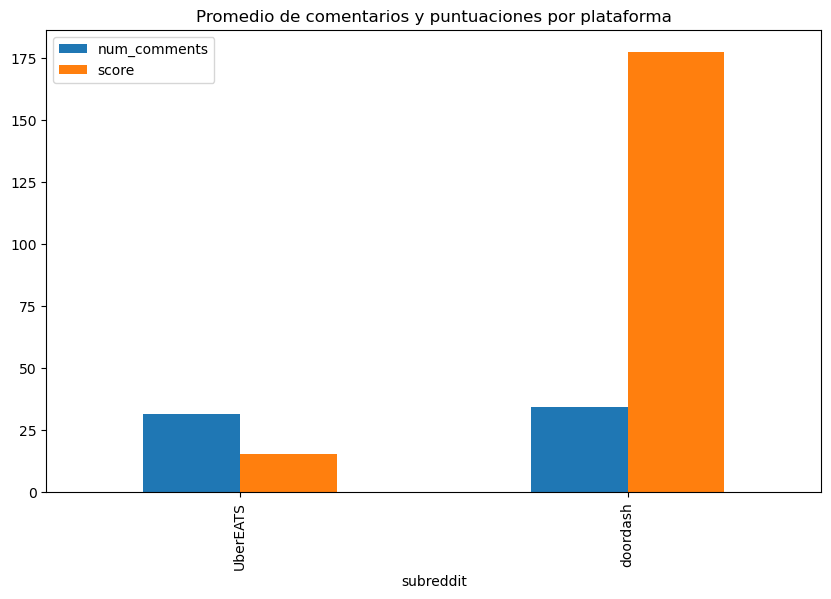

In [30]:
# Comparar la media de 'num_comments' y 'score' entre plataformas
df.groupby('subreddit')[['num_comments', 'score']].mean().plot(kind='bar', figsize=(10, 6))
plt.title('Promedio de comentarios y puntuaciones por plataforma')
plt.show()

In [34]:
# Step 1: Count the number of words in the title and in the clean text
df['word_count_title'] = df['clean_title'].apply(lambda x: len(x.split()))
df['word_count_self_text'] = df['clean_self_text'].apply(lambda x: len(x.split()))

# Step 2: Group by subreddit and calculate statistics
word_count_stats_title = df.groupby('subreddit')['word_count_title'].agg(['mean', 'median', 'min', 'max', 'std'])
word_count_stats_self_text = df.groupby('subreddit')['word_count_self_text'].agg(['mean', 'median', 'min', 'max', 'std'])

# Step 3: Display the results
print("Title word statistics by subreddit:")
print(word_count_stats_title)

print("\nWords in text statistics by subreddit:")
print(word_count_stats_self_text)

Title word statistics by subreddit:
               mean  median  min  max       std
subreddit                                      
UberEATS   4.622785     4.0    0   30  3.253167
doordash   4.359507     4.0    0   27  3.201545

Words in text statistics by subreddit:
                mean  median  min  max        std
subreddit                                        
UberEATS   44.619409    30.0    0  476  50.539884
doordash   33.133030    20.0    0  528  41.539980


In [32]:
df.groupby('subreddit')['word_count_title'].describe(percentiles=[.25, .5, .75])


,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
UberEATS,1185.0,4.622785,3.253167,0.0,3.0,4.0,6.0,30.0
doordash,1541.0,4.359507,3.201545,0.0,2.0,4.0,5.0,27.0


In [88]:
df.groupby('subreddit')['word_count_self_text'].describe(percentiles=[.25, .5, .75])

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
UberEATS,1185.0,44.711392,50.459370,0.0,13.0,30.0,59.0,476.0
doordash,1541.0,33.299805,41.408336,0.0,6.0,20.0,44.0,528.0


In [51]:
def check_signig_class(var):
    # Paso 1: Filtrar los datos por subreddit
    doordash_data = df[df['subreddit'] == 'doordash'][var]
    ubereats_data = df[df['subreddit'] == 'UberEATS'][var]
    
    # Paso 2: Realizar el t-test de Student
    t_stat, p_value = ttest_ind(doordash_data.dropna(), ubereats_data.dropna())  # .dropna() para eliminar valores nulos
        
    # Interpretación:
    if p_value < 0.05:
        return(f"T-statistic: {t_stat} P-value: {p_value} We reject the null hypothesis, there is a significant difference between classes on {var}.")
    else:
        return(f"T-statistic: {t_stat} P-value: {p_value} We do not reject the null hypothesis, there is no significant difference between classes on {var}.")

print(check_signig_class('word_count_title'))
print(check_signig_class('word_count_self_text'))

T-statistic: -2.1135169225506774 P-value: 0.034647238622650796 We reject the null hypothesis, there is a significant difference between classes on word_count_title.
T-statistic: -6.509493590280196 P-value: 8.944340233511906e-11 We reject the null hypothesis, there is a significant difference between classes on word_count_self_text.


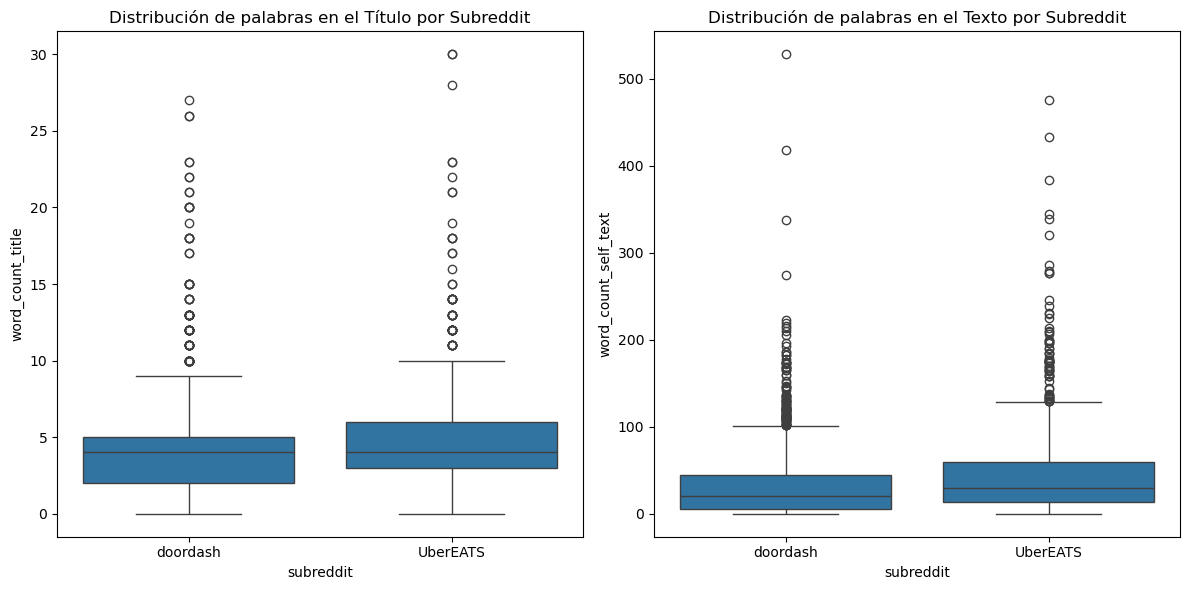

In [52]:
# Paso 1: Calcular los percentiles, mediana y otros valores
# Para el título
word_count_stats_title = df.groupby('subreddit')['word_count_title'].describe(percentiles=[.25, .5, .75])

# Para el texto
word_count_stats_self_text = df.groupby('subreddit')['word_count_self_text'].describe(percentiles=[.25, .5, .75])

# Paso 2: Crear los gráficos de caja
plt.figure(figsize=(12, 6))

# Gráfico de palabras en el título por subreddit
plt.subplot(1, 2, 1)
sns.boxplot(x='subreddit', y='word_count_title', data=df)
plt.title('Distribución de palabras en el Título por Subreddit')

# Gráfico de palabras en el texto por subreddit
plt.subplot(1, 2, 2)
sns.boxplot(x='subreddit', y='word_count_self_text', data=df)
plt.title('Distribución de palabras en el Texto por Subreddit')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [53]:
# Inicializar el analizador de sentimientos
sia = SentimentIntensityAnalyzer()

# Función para obtener el puntaje de sentimiento
def analyze_sentiment(text):
    # Asegurarse de que el texto no sea nulo
    if pd.isnull(text):
        return {'pos': 0, 'neu': 0, 'neg': 0, 'compound': 0}
    
    # Obtener los valores de sentimiento
    sentiment = sia.polarity_scores(text)
    return sentiment

# Aplicar el análisis de sentimiento a 'clean_title' y 'clean_self_text'
df['sentiment_title'] = df['clean_title'].apply(analyze_sentiment)
df['sentiment_self_text'] = df['clean_self_text'].apply(analyze_sentiment)

# Extraer los puntajes de sentimiento de las columnas de diccionario
df['sentiment_title_pos'] = df['sentiment_title'].apply(lambda x: x['pos'])
df['sentiment_title_neg'] = df['sentiment_title'].apply(lambda x: x['neg'])
df['sentiment_title_neu'] = df['sentiment_title'].apply(lambda x: x['neu'])
df['sentiment_title_compound'] = df['sentiment_title'].apply(lambda x: x['compound'])

df['sentiment_self_text_pos'] = df['sentiment_self_text'].apply(lambda x: x['pos'])
df['sentiment_self_text_neg'] = df['sentiment_self_text'].apply(lambda x: x['neg'])
df['sentiment_self_text_neu'] = df['sentiment_self_text'].apply(lambda x: x['neu'])
df['sentiment_self_text_compound'] = df['sentiment_self_text'].apply(lambda x: x['compound'])

In [54]:
# Agrupar por subreddit y calcular estadísticas descriptivas de 'compound'
subreddit_sentiment = df.groupby('subreddit')['sentiment_self_text_compound'].describe()
print(subreddit_sentiment)

            count      mean       std     min     25%  50%     75%     max
subreddit                                                                 
UberEATS   1185.0  0.082245  0.544998 -0.9900 -0.3182  0.0  0.5574  0.9955
doordash   1541.0  0.081187  0.497162 -0.9845 -0.1779  0.0  0.4588  0.9943


In [55]:
# Agrupar por subreddit y calcular estadísticas descriptivas de 'compound'
subreddit_sentiment = df.groupby('subreddit')['sentiment_self_text_neg'].describe()
print(subreddit_sentiment)

            count      mean       std  min  25%    50%    75%    max
subreddit                                                           
UberEATS   1185.0  0.105363  0.112602  0.0  0.0  0.091  0.161  1.000
doordash   1541.0  0.093454  0.113676  0.0  0.0  0.065  0.151  0.778


In [56]:
print(check_signig_class('sentiment_title_compound'))

T-statistic: 1.5378099863956767 P-value: 0.12421122375569905 We do not reject the null hypothesis, there is no significant difference between classes on sentiment_title_compound.


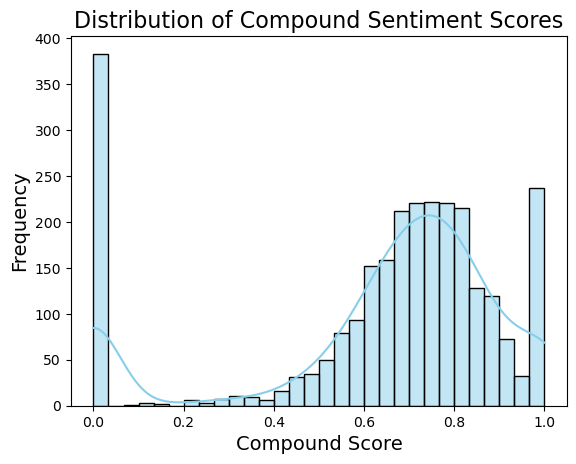

In [57]:
sns.histplot(df['sentiment_self_text_neu'], bins=30, kde=True, color='skyblue')

# Add titles and labels
plt.title('Distribution of Compound Sentiment Scores', fontsize=16)
plt.xlabel('Compound Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.show()

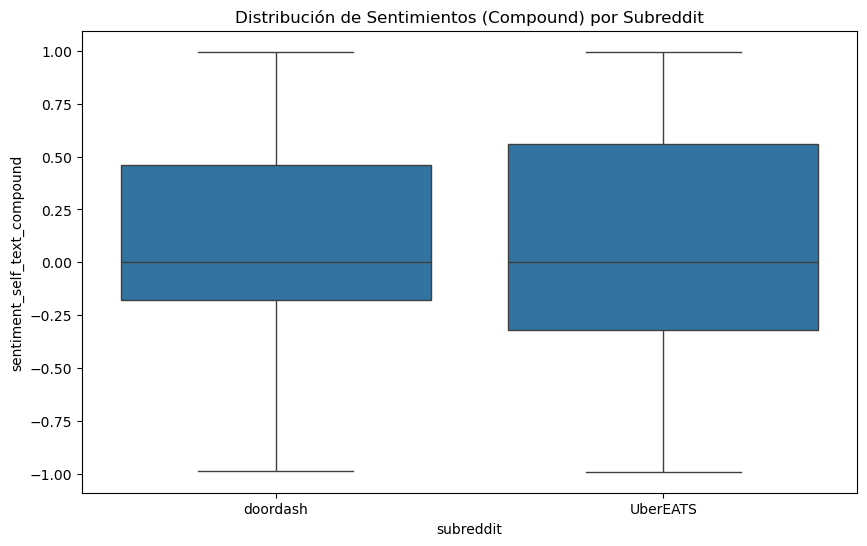

In [58]:
import seaborn as sns

# Boxplot para visualizar la distribución de sentimientos por subreddit
plt.figure(figsize=(10, 6))
sns.boxplot(x='subreddit', y='sentiment_self_text_compound', data=df)
plt.title('Distribución de Sentimientos (Compound) por Subreddit')
plt.show()

In [68]:
df['has_media'] = df['media'].apply(lambda x: 0 if x=='n' else 1)

In [69]:
df.to_csv('Datasets/post_reddit_eda.csv', index=False)

In [67]:
# 5. Statistical Analysis

In [62]:
print(check_signig_class('has_media'))
print(check_signig_class('num_comments'))
print(check_signig_class('score'))
print(check_signig_class('sentiment_self_text_pos'))
print(check_signig_class('sentiment_title_pos'))
print(check_signig_class('sentiment_title_neu'))
print(check_signig_class('sentiment_self_text_neu'))

T-statistic: 11.454285754328154 P-value: 1.0589531726654247e-29 We reject the null hypothesis, there is a significant difference between classes on has_media.
T-statistic: 0.42142007078508287 P-value: 0.6734816160416922 We do not reject the null hypothesis, there is no significant difference between classes on num_comments.
T-statistic: 2.423286621607568 P-value: 0.015445551799517985 We reject the null hypothesis, there is a significant difference between classes on score.
T-statistic: -0.44621756404499446 P-value: 0.655475563319626 We do not reject the null hypothesis, there is no significant difference between classes on sentiment_self_text_pos.
T-statistic: 1.9231976795834866 P-value: 0.054559355295802144 We do not reject the null hypothesis, there is no significant difference between classes on sentiment_title_pos.
T-statistic: -1.2371648597764127 P-value: 0.21613252361661536 We do not reject the null hypothesis, there is no significant difference between classes on sentiment_title

In [63]:
grouped = df.groupby(['subreddit', 'has_media']).size().reset_index(name='count')
grouped



,subreddit,has_media,count
0,UberEATS,0,883
1,UberEATS,1,302
2,doordash,0,826
3,doordash,1,715


In [64]:
df.dtypes

title                            object
self_text                        object
type_user                        object
Description                      object
subreddit                        object
num_comments                      int64
score                             int64
upvote_ratio                    float64
author                           object
media                            object
has_self_text                     int64
has_author                        int64
emojis_title                     object
emojis_self_text                 object
clean_title                      object
clean_self_text                  object
has_emojis_self_text              int64
has_emojis_title                  int64
full_text                        object
word_count_title                  int64
word_count_self_text              int64
sentiment_title                  object
sentiment_self_text              object
sentiment_title_pos             float64
sentiment_title_neg             float64
